TODO:
    - Stack all three years of tracking data
    - Add all players to model features
    - Standardize punt directional data

In [ ]:
%matplotlib notebook

In [2]:
from types import SimpleNamespace

import matplotlib.animation as anm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

COLUMN = SimpleNamespace(**{
    'PLAY_TYPE': 'specialTeamsPlayType',
    'SPECIAL_TEAMS_RESULT': 'specialTeamsResult',
    'PLAY_RESULT': 'playResult', # Net difference in field position
    'POSITION': 'position',
    'PLAY_EVENT': 'event',
    'GAME_ID': 'gameId',
    'PLAY_ID': 'playId',
    'GUNNERS': 'gunners',
    'GUNNER_LIST': 'gunnerList',
    'HOME_TEAM': 'homeTeamAbbr',
    'VISITOR_TEAM': 'visitorTeamAbbr',
    'IS_GUNNER': 'isGunner',
    'JERSEY_NUMBER': 'jerseyNumber',
    'TEAM': 'team',
    'POSSESSION_TEAM': 'possessionTeam',
    'TIME': 'time',
    'NFL_ID': 'nflId',
    'RETURNER_ID': 'returnerId',
    'PRIMARY_RETURNER_ID': 'primaryReturnerId',
    'PLAYER_TEAM_ID': 'playerTeamId',
    'X': 'x',
    'Y': 'y',
    'COLOR': 'color',
    'FRAME': 'frame',
    'DISPLAY_NAME': 'displayName',
    'KICK_RETURN_YARDAGE': 'kickReturnYardage',
    'DISTANCE_FROM_SIDELINE': 'distanceFromSideline',
    'SORT_POSITION': 'sortPosition',
})

POSITION = SimpleNamespace(**{
    'KICKER': 'K',
    'PUNTER': 'P',
    'LONG_SNAPPER': 'LS',
})

PLAY_TYPE = SimpleNamespace(**{
    'FIELD_GOAL': 'Field Goal',
    'PUNT': 'Punt',
})

PLAY_EVENT = SimpleNamespace(**{
    'BALL_SNAP': 'ball_snap',
    'FG_ATTEMPT': 'field_goal_attempt',
    'PUNT': 'punt',
    'PUNT_RECEIVED': 'punt_received',
    'OUT_OF_BOUNDS': 'out_of_bounds',
    'PUNT_LAND': 'punt_land',
    'FAIR_CATCH': 'fair_catch',
    'PUNT_MUFFED': 'punt_muffed',
})

SPECIAL_TEAMS_RESULT = SimpleNamespace(**{
    'BLOCKED': 'Blocked Kick Attempt',
    'DOWNED': 'Downed',
    'KICK_GOOD': 'Kick Attempt Good',
    'KICK_NO_GOOD': 'Kick Attempt No Good',
    'RETURN': 'Return',
    'TOUCHBACK': 'Touchback',
    'FAIR_CATCH': 'Fair Catch',
    'MUFFED': 'Muffed',
    'OUT_OF_BOUNDS': 'Out of Bounds',
})

TEAM = SimpleNamespace(**{
    'HOME': 'home',
    'AWAY': 'away',
    'FOOTBALL': 'football',
})

In [3]:
games_df = pd.read_csv('input/games.csv')
players_df = pd.read_csv('input/players.csv')
plays_df = pd.read_csv('input/plays.csv')
pff_scouting_df = pd.read_csv('input/PFFScoutingData.csv')
tracking_2018_df = pd.read_csv('input/tracking2018.csv')
game_plays_df = pd.merge(games_df, plays_df, left_on=COLUMN.GAME_ID, right_on=COLUMN.GAME_ID)

In [4]:
game_plays_df = game_plays_df.dropna(subset=[COLUMN.RETURNER_ID])

def getPrimaryReturnerId(value):
    returners = str(value).split(';')
    return int(returners[0])

game_plays_df[COLUMN.PRIMARY_RETURNER_ID] = game_plays_df[COLUMN.RETURNER_ID] \
    .apply(getPrimaryReturnerId) \
    .astype('Int64')

tracking_2018_df[COLUMN.TIME] = pd.to_datetime(tracking_2018_df[COLUMN.TIME])
tracking_2018_df[COLUMN.JERSEY_NUMBER] = tracking_2018_df[COLUMN.JERSEY_NUMBER].astype('Int64')
tracking_2018_df[COLUMN.NFL_ID] = tracking_2018_df[COLUMN.NFL_ID].astype('Int64')

In [5]:
punt_tracking_2018_df = pd.merge(
    pff_scouting_df,
    tracking_2018_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)
punt_plays_df = game_plays_df[game_plays_df[COLUMN.PLAY_TYPE] == PLAY_TYPE.PUNT]
punt_tracking_2018_df = pd.merge(
    punt_tracking_2018_df,
    punt_plays_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)

In [6]:
conditions = [
    (punt_tracking_2018_df[COLUMN.TEAM] == TEAM.HOME),
    (punt_tracking_2018_df[COLUMN.TEAM] == TEAM.AWAY),
]

values = [
    punt_tracking_2018_df[COLUMN.HOME_TEAM] + ' ' + punt_tracking_2018_df[COLUMN.JERSEY_NUMBER].astype(str),
    punt_tracking_2018_df[COLUMN.VISITOR_TEAM] + ' ' + punt_tracking_2018_df[COLUMN.JERSEY_NUMBER].astype(str),
]

punt_tracking_2018_df[COLUMN.PLAYER_TEAM_ID] = np.select(conditions, values)

def splitGunners(value):
    if value is None:
        return []
    gunners = str(value).split(';')
    return [gunner.strip() for gunner in gunners]

punt_tracking_2018_df[COLUMN.GUNNER_LIST] = punt_tracking_2018_df[COLUMN.GUNNERS].apply(splitGunners)

punt_tracking_2018_df[COLUMN.IS_GUNNER] = punt_tracking_2018_df.apply(
    lambda x: str(x[COLUMN.PLAYER_TEAM_ID]) in x[COLUMN.GUNNER_LIST],
    axis=1,
)

<IPython.core.display.Javascript object>


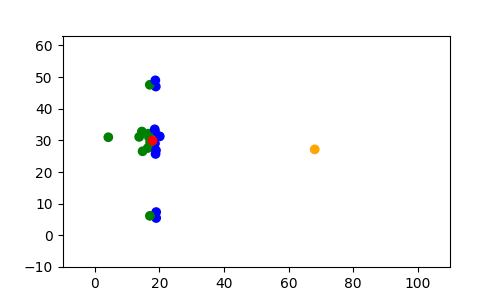

In [7]:
punt_tracking_2018_df.loc[:, COLUMN.FRAME] = punt_tracking_2018_df[[COLUMN.GAME_ID, COLUMN.TIME]] \
    .apply(tuple, axis=1) \
    .rank(ascending=True, method='dense')

is_returner = np.where(punt_tracking_2018_df[COLUMN.PRIMARY_RETURNER_ID].fillna(-1) == punt_tracking_2018_df[COLUMN.NFL_ID].fillna(-2), True, False)

conditions = [
#     punt_tracking_2018_df[COLUMN.IS_GUNNER],
    is_returner,
    punt_tracking_2018_df[COLUMN.TEAM] == TEAM.HOME,
    punt_tracking_2018_df[COLUMN.TEAM] == TEAM.AWAY,
    punt_tracking_2018_df[COLUMN.TEAM] == TEAM.FOOTBALL,
]
values = [
    'orange',
    'green',
    'blue',
    'red',
]
punt_tracking_2018_df.loc[:, COLUMN.COLOR] = np.select(conditions, values)

fig, ax = plt.subplots(figsize=(5, 3))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
first_frame = punt_tracking_2018_df[punt_tracking_2018_df[COLUMN.FRAME] == 1]
c = first_frame[COLUMN.COLOR]
x = first_frame[COLUMN.X]
y = first_frame[COLUMN.Y]
scatter = ax.scatter(x, y, c=c)

def animate(i):
    filtered = punt_tracking_2018_df[punt_tracking_2018_df[COLUMN.FRAME] == i+1]
    c = filtered[COLUMN.COLOR]
    x = filtered[COLUMN.X]
    y = filtered[COLUMN.Y]
    data = np.c_[x, y]
    scatter.set_offsets(data)
    scatter.set_color(c)

animation = anm.FuncAnimation(
    fig,
    animate,
    interval=10,
    frames=int(punt_tracking_2018_df[COLUMN.FRAME].max()),
    repeat=True,
)
plt.show()

In [8]:
# Punt distance from sideline vs return distance
punt_tracking_2018_df['sidelineA'] = 53.3 - punt_tracking_2018_df[COLUMN.Y]
punt_tracking_2018_df['sidelineB'] = punt_tracking_2018_df[COLUMN.Y]
punt_tracking_2018_df[COLUMN.DISTANCE_FROM_SIDELINE] = punt_tracking_2018_df[['sidelineA', 'sidelineB']].min(axis=1)

<IPython.core.display.Javascript object>


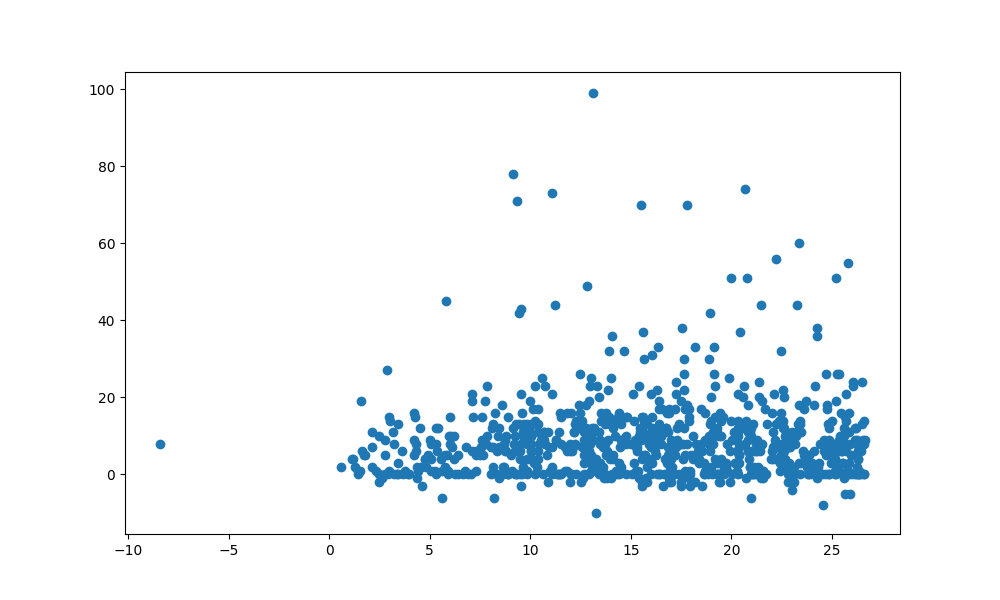

In [9]:
punt_received_football_only_df = punt_tracking_2018_df[
    (punt_tracking_2018_df[COLUMN.PLAY_EVENT] == PLAY_EVENT.PUNT_RECEIVED)
    & (punt_tracking_2018_df[COLUMN.TEAM] == 'football')
]
x = punt_received_football_only_df[COLUMN.DISTANCE_FROM_SIDELINE]
y = punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE]
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x, y)
plt.show()

In [10]:
x.corr(y)

0.035468871186775344

In [11]:
punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE].mean()

8.923543689320388

In [12]:
punt_received_football_only_df['aboveAverageReturn'] = \
    punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE] > punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE].mean()
punt_received_football_only_df[
    [COLUMN.X, COLUMN.Y, COLUMN.DISTANCE_FROM_SIDELINE, COLUMN.KICK_RETURN_YARDAGE, 'aboveAverageReturn']
].head()

/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_29786/3108297030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  punt_received_football_only_df['aboveAverageReturn'] = \


,x,y,distanceFromSideline,kickReturnYardage,aboveAverageReturn
2893,72.61,39.18,14.12,5.0,False
7911,91.77,35.94,17.36,8.0,False
12720,82.02,42.04,11.26,9.0,True
19308,30.37,32.33,20.97,12.0,True
22523,36.61,44.87,8.43,-1.0,False


<IPython.core.display.Javascript object>


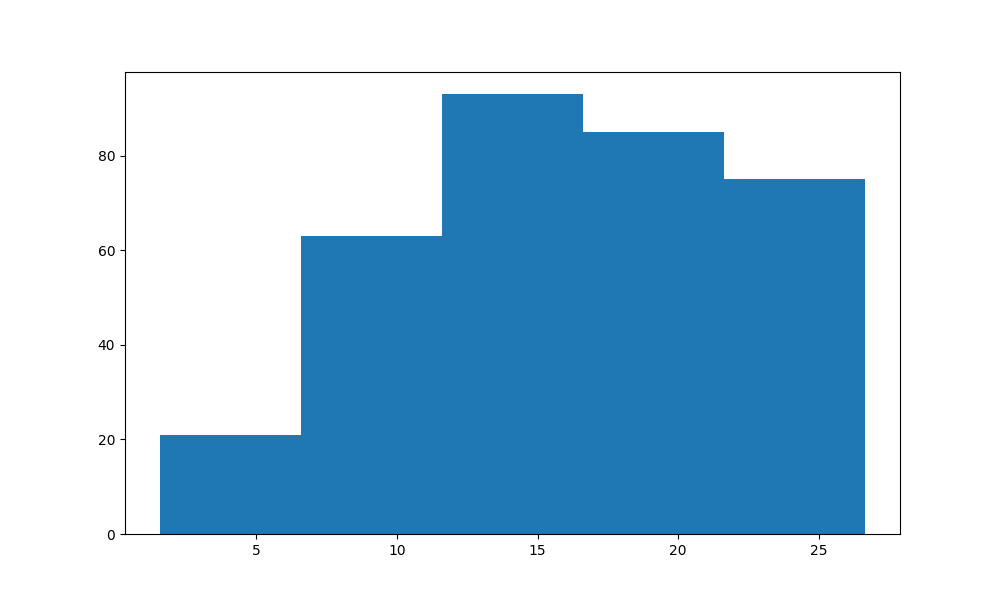

In [13]:
above_average_returns_df = punt_received_football_only_df[punt_received_football_only_df['aboveAverageReturn'] == True]
x = above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE]
bins = 5
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(x=x, bins=bins)
plt.show()

In [14]:
above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE].corr(above_average_returns_df[COLUMN.KICK_RETURN_YARDAGE])

0.04671642827966678

<IPython.core.display.Javascript object>


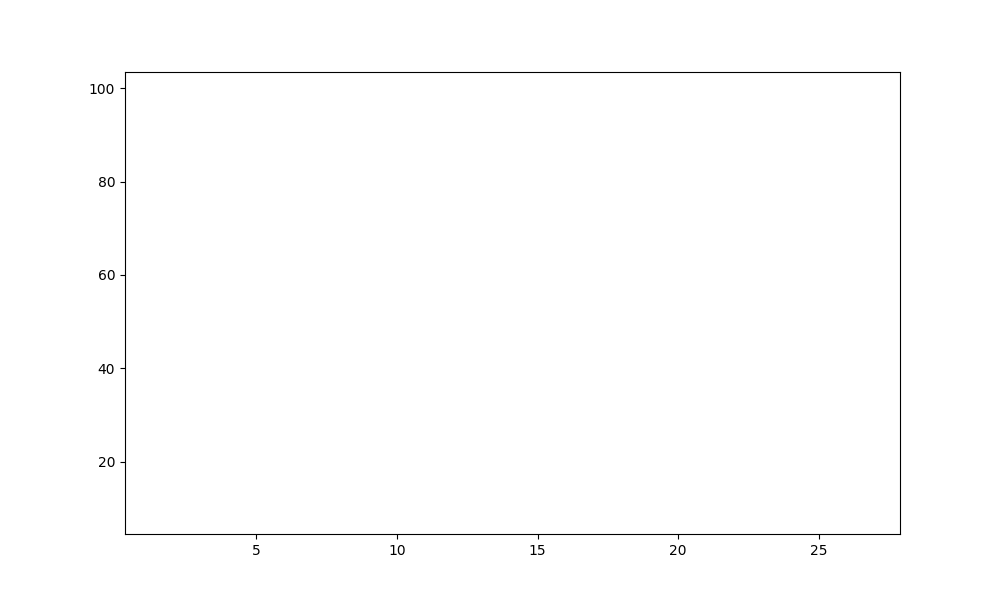

In [15]:
x = above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE]
y = above_average_returns_df[COLUMN.KICK_RETURN_YARDAGE]
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x, y)
plt.show()

In [16]:
'''
Predict punt landing position based on pre-snap inputs (e.g. ball position)

Inputs:
  - Positions of all players and ball at time of snap (22 players + ball, x and y positions)
Outputs:
  - Ball landing position x, y
  
TODO:
  - Stack all 3 years of data
  - For inputs, filter tracking data to play event = ball_snap and special teams result
       is one of Return', 'Touchback', 'Fair Catch', 'Downed', 'Muffed', 'Out of Bounds'
  - For outputs, filter to football position when special teams result is one of Return', 'Touchback',
       'Fair Catch', 'Downed', 'Muffed', 'Out of Bounds'
       AND play event is one of punt_received, punt_land,
       fair_catch, punt_muffed
       AND team is football
  - Partition/sync inputs and outputs based on game id and play id
  - Partition data into training data and test data (80/20)
  - Use sklearn.linear_model.LinearRegression to train and test
  - Visualize results
  
A, B, C, D, E, F

A * x0 + B * x1 + C * x2 + D * x3 ... = ball landing position

                      SORT
x0 = ball x           1
x1 = ball y           2
x2 = punter x
x3 = punter y
x4 = returner x
x5 = returner y

y0 = ball landing x
y1 = ball landing y

football filter COLUMN.TEAM == 'football'
punter filter COLUMN.POSITION == 'P'
returner filter returnerId == nflId 
'''
special_teams_results = [
    SPECIAL_TEAMS_RESULT.RETURN,
    SPECIAL_TEAMS_RESULT.TOUCHBACK,
    SPECIAL_TEAMS_RESULT.FAIR_CATCH,
    SPECIAL_TEAMS_RESULT.DOWNED,
    SPECIAL_TEAMS_RESULT.MUFFED,
    SPECIAL_TEAMS_RESULT.OUT_OF_BOUNDS,
]
ball_land_events = [
    PLAY_EVENT.PUNT_RECEIVED,
    PLAY_EVENT.PUNT_LAND,
    PLAY_EVENT.FAIR_CATCH,
    PLAY_EVENT.PUNT_MUFFED,
]
punt_predict_df = punt_tracking_2018_df[
    punt_tracking_2018_df[COLUMN.SPECIAL_TEAMS_RESULT].isin(special_teams_results)
]

In [17]:
is_football = punt_predict_df[COLUMN.TEAM] == TEAM.FOOTBALL
is_punter = punt_predict_df[COLUMN.POSITION] == POSITION.PUNTER
is_returner = (~np.isnan(punt_predict_df[COLUMN.PRIMARY_RETURNER_ID])) \
    & (~np.isnan(punt_predict_df[COLUMN.NFL_ID])) \
    & (punt_predict_df[COLUMN.PRIMARY_RETURNER_ID] == punt_predict_df[COLUMN.NFL_ID])
inputs_df = punt_predict_df[
    (punt_predict_df[COLUMN.PLAY_EVENT] == PLAY_EVENT.BALL_SNAP)
    & ((is_football) | (is_punter) | (is_returner))
    & (punt_predict_df[COLUMN.RETURNER_ID].str.contains(';') == False) # filter out multiple returner scenarios
]

conditions = [
    (inputs_df[COLUMN.TEAM] == TEAM.FOOTBALL),
    (inputs_df[COLUMN.POSITION] == POSITION.PUNTER),
    np.where(inputs_df[COLUMN.PRIMARY_RETURNER_ID].fillna(-1) == inputs_df[COLUMN.NFL_ID].fillna(-2), True, False),
]
values = [1, 2, 3]
inputs_df[COLUMN.SORT_POSITION] = np.select(conditions, values)

inputs_df = inputs_df.sort_values(by=[COLUMN.GAME_ID, COLUMN.PLAY_ID, COLUMN.SORT_POSITION])

aggs = { 'x': lambda x: x.to_list(), 'y': lambda y: y.to_list() }
inputs_df = inputs_df.groupby([COLUMN.GAME_ID, COLUMN.PLAY_ID]).agg(aggs).reset_index()
inputs_df = inputs_df[
    (inputs_df[COLUMN.X].map(len) == 3)
    & (inputs_df[COLUMN.Y].map(len) == 3)
]
# Filter out plays where returner is near line of scrimmage
inputs_df = inputs_df[
    np.abs(inputs_df[COLUMN.X].str[0] - inputs_df[COLUMN.X].str[2]) > 10
]

def merge_coordinates(df):
    return [
        df[COLUMN.X][0],
        df[COLUMN.Y][0],
        df[COLUMN.X][1],
        df[COLUMN.Y][1],
        df[COLUMN.X][2],
        df[COLUMN.Y][2],
    ]

inputs_df['features'] = inputs_df.apply(merge_coordinates, axis=1)

/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_29786/3293556865.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs_df[COLUMN.SORT_POSITION] = np.select(conditions, values)


In [18]:
outputs_df = punt_predict_df[
    (punt_tracking_2018_df[COLUMN.PLAY_EVENT].isin(ball_land_events))
    & (punt_tracking_2018_df[COLUMN.TEAM] == TEAM.FOOTBALL)
].sort_values(by=[COLUMN.GAME_ID, COLUMN.PLAY_ID])

def adjust_y(value):
    width = 53.3
    midline = width / 2
    if value < midline:
        return value
    else:
        return width - value

outputs_df['yAdjusted'] = outputs_df[COLUMN.Y].apply(adjust_y)

In [19]:
model_data_df = pd.merge(
    inputs_df,
    outputs_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)

X = np.array(model_data_df['features'].tolist())
y = model_data_df[['x_y', 'y_y']].to_numpy()

In [20]:
model_data_df[[COLUMN.GAME_ID, COLUMN.PLAY_ID, 'x_x', 'y_x', 'features', 'x_y', 'y_y', 'yAdjusted']].head(10)

,gameId,playId,x_x,y_x,features,x_y,y_y,yAdjusted
0,2018090600,366,"[17.9, 4.2, 67.05]","[29.94, 31.01, 26.31]","[17.9, 29.94, 4.2, 31.01, 67.05, 26.31]",72.61,39.18,14.12
1,2018090600,973,"[20.8, 7.04, 68.89]","[29.88, 29.32, 34.84]","[20.8, 29.88, 7.04, 29.32, 68.89, 34.84]",68.90,48.79,4.51
2,2018090600,1989,"[35.82, 22.04, 85.21]","[23.79, 23.28, 28.81]","[35.82, 23.79, 22.04, 23.28, 85.21, 28.81]",91.77,35.94,17.36
3,2018090600,2406,"[68.43, 81.79, 20.34]","[29.6, 28.88, 31.25]","[68.43, 29.6, 81.79, 28.88, 20.34, 31.25]",29.47,23.76,23.76
4,2018090600,2599,"[36.0, 22.03, 81.78]","[26.47, 26.11, 29.42]","[36.0, 26.47, 22.03, 26.11, 81.78, 29.42]",82.02,42.04,11.26
5,2018090600,3868,"[81.16, 94.96, 35.1]","[23.81, 22.94, 28.2]","[81.16, 23.81, 94.96, 22.94, 35.1, 28.2]",30.37,32.33,20.97
6,2018090900,485,"[82.0, 96.11, 36.87]","[29.87, 29.52, 30.99]","[82.0, 29.87, 96.11, 29.52, 36.87, 30.99]",36.61,44.87,8.43
7,2018090900,575,"[35.74, 22.18, 80.94]","[23.63, 24.7, 29.79]","[35.74, 23.63, 22.18, 24.7, 80.94, 29.79]",90.69,48.90,4.40
8,2018090900,575,"[35.74, 22.18, 80.94]","[23.63, 24.7, 29.79]","[35.74, 23.63, 22.18, 24.7, 80.94, 29.79]",98.16,52.11,1.19
9,2018090900,674,"[92.04, 106.19, 44.66]","[23.95, 23.23, 28.34]","[92.04, 23.95, 106.19, 23.23, 44.66, 28.34]",41.47,38.14,15.16


In [21]:
X

array([[ 17.9 ,  29.94,   4.2 ,  31.01,  67.05,  26.31],
       [ 20.8 ,  29.88,   7.04,  29.32,  68.89,  34.84],
       [ 35.82,  23.79,  22.04,  23.28,  85.21,  28.81],
       ...,
       [ 78.8 ,  29.83,  93.71,  28.83,  36.42,  32.31],
       [ 36.34,  29.8 ,  22.82,  29.4 ,  84.41,  30.94],
       [ 95.2 ,  23.75, 109.66,  23.95,  48.55,  19.67]])

In [22]:
y

array([[72.61, 39.18],
       [68.9 , 48.79],
       [91.77, 35.94],
       ...,
       [36.8 , 32.31],
       [86.27, 47.85],
       [33.62, 39.09]])

In [23]:
reg = LinearRegression().fit(X, y)

In [24]:
reg.score(X, y)

0.6319169701195959

In [25]:
reg.coef_

array([[ 0.76358411, -0.1564124 , -0.66153308,  0.13117015,  0.72221295,
         0.07886428],
       [ 0.29372678,  4.9436276 , -0.220667  , -4.96476254, -0.0123593 ,
         1.22377803]])

In [26]:
reg.intercept_

array([ 9.16035269, -9.09368755])

In [27]:
reg.predict(np.array([[17.9 ,  29.94,   4.2 ,  31.01,  67.05,  26.31]]))

array([[69.93396574, 20.66105354]])

In [28]:
model_data_df["prediction"] = reg.predict(X).tolist()

In [29]:
model_data_df[[COLUMN.GAME_ID, COLUMN.PLAY_ID, 'x_x', 'y_x', 'features', 'x_y', 'y_y', 'prediction']].head(10)

,gameId,playId,x_x,y_x,features,x_y,y_y,prediction
0,2018090600,366,"[17.9, 4.2, 67.05]","[29.94, 31.01, 26.31]","[17.9, 29.94, 4.2, 31.01, 67.05, 26.31]",72.61,39.18,"[69.93396573573813, 20.661053543113006]"
1,2018090600,973,"[20.8, 7.04, 68.89]","[29.88, 29.32, 34.84]","[20.8, 29.88, 7.04, 29.32, 68.89, 34.84]",68.90,48.79,"[72.05889699611765, 39.39608345952753]"
2,2018090600,1989,"[35.82, 22.04, 85.21]","[23.79, 23.28, 28.81]","[35.82, 23.79, 22.04, 23.28, 85.21, 28.81]",91.77,35.94,"[85.07618169630345, 32.797243089461745]"
3,2018090600,2406,"[68.43, 81.79, 20.34]","[29.6, 28.88, 31.25]","[68.43, 29.6, 81.79, 28.88, 20.34, 31.25]",29.47,23.76,"[23.618329587654507, 33.89839242445244]"
4,2018090600,2599,"[36.0, 22.03, 81.78]","[26.47, 26.11, 29.42]","[36.0, 26.47, 22.03, 26.11, 81.78, 29.42]",82.02,42.04,"[82.74318525220946, 32.83986155706876]"
5,2018090600,3868,"[81.16, 94.96, 35.1]","[23.81, 22.94, 28.2]","[81.16, 23.81, 94.96, 22.94, 35.1, 28.2]",30.37,32.33,"[35.17216884455584, 31.683489400111643]"
6,2018090900,485,"[82.0, 96.11, 36.87]","[29.87, 29.52, 30.99]","[82.0, 29.87, 96.11, 29.52, 36.87, 30.99]",36.61,44.87,"[36.46640513945877, 32.359163355863174]"
7,2018090900,575,"[35.74, 22.18, 80.94]","[23.63, 24.7, 29.79]","[35.74, 23.63, 22.18, 24.7, 80.94, 29.79]",90.69,48.90,"[82.12720562976264, 26.153985023287742]"
8,2018090900,575,"[35.74, 22.18, 80.94]","[23.63, 24.7, 29.79]","[35.74, 23.63, 22.18, 24.7, 80.94, 29.79]",98.16,52.11,"[82.12720562976264, 26.153985023287742]"
9,2018090900,674,"[92.04, 106.19, 44.66]","[23.95, 23.23, 28.34]","[92.04, 23.95, 106.19, 23.23, 44.66, 28.34]",41.47,38.14,"[42.982485875028345, 31.706647137514356]"


<IPython.core.display.Javascript object>


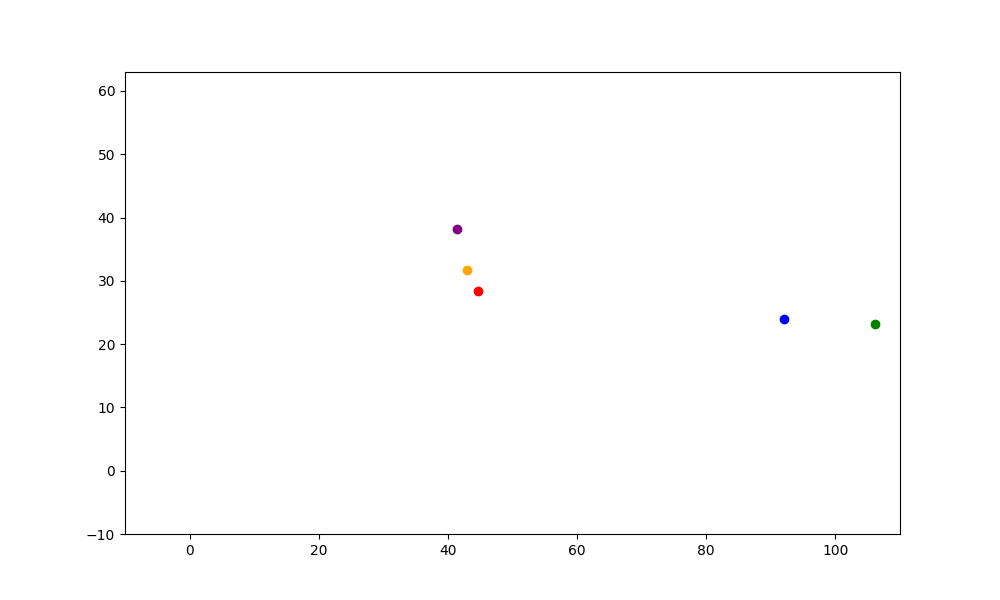

In [30]:
row = 9
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
c = 'blue'
football_x = model_data_df.iloc[row]['x_x'][0]
football_y = model_data_df.iloc[row]['y_x'][0]
ax.scatter(x=football_x, y=football_y, c=c)
c = 'green'
punter_x = model_data_df.iloc[row]['x_x'][1]
punter_y = model_data_df.iloc[row]['y_x'][1]
ax.scatter(x=punter_x, y=punter_y, c=c)
c = 'red'
returner_x = model_data_df.iloc[row]['x_x'][2]
returner_y = model_data_df.iloc[row]['y_x'][2]
ax.scatter(x=returner_x, y=returner_y, c=c)
c = 'purple'
actual_x = model_data_df.iloc[row]['x_y']
actual_y = model_data_df.iloc[row]['y_y']
ax.scatter(x=actual_x, y=actual_y, c=c)
c = 'orange'
predict_x = model_data_df.iloc[row]['prediction'][0]
predict_y = model_data_df.iloc[row]['prediction'][1]
ax.scatter(x=predict_x, y=predict_y, c=c)
plt.show()

In [31]:
# Predict X
model_data_df['prediction'].str[0].describe()

count    1519.000000
mean       60.764516
std        28.329390
min        18.023792
25%        32.390077
50%        68.574755
75%        87.377130
max       102.092425
Name: prediction, dtype: float64

In [32]:
# Actual X
model_data_df['x_y'].describe()

count    1519.000000
mean       60.764516
std        29.007040
min        13.510000
25%        31.700000
50%        65.440000
75%        88.025000
max       109.640000
Name: x_y, dtype: float64

In [33]:
# Predict Y
model_data_df['prediction'].str[1].describe()

count    1519.000000
mean       26.907716
std         7.314971
min         4.569115
25%        21.195621
50%        27.066585
75%        32.381700
max        47.826935
Name: prediction, dtype: float64

In [34]:
# Actual Y
model_data_df['y_y'].describe()

count    1519.000000
mean       26.907716
std        13.137837
min        -8.400000
25%        16.295000
50%        27.430000
75%        37.680000
max        55.650000
Name: y_y, dtype: float64

In [35]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(23 * 2 * 10, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model

model = get_model(X.shape[1], y.shape[1])

2021-12-10 14:37:14.889603: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [50]:
model.fit(X, y, verbose=0, epochs=1000)

In [51]:
model_data_df['nn_prediction'] = model.predict(X).tolist()

<IPython.core.display.Javascript object>


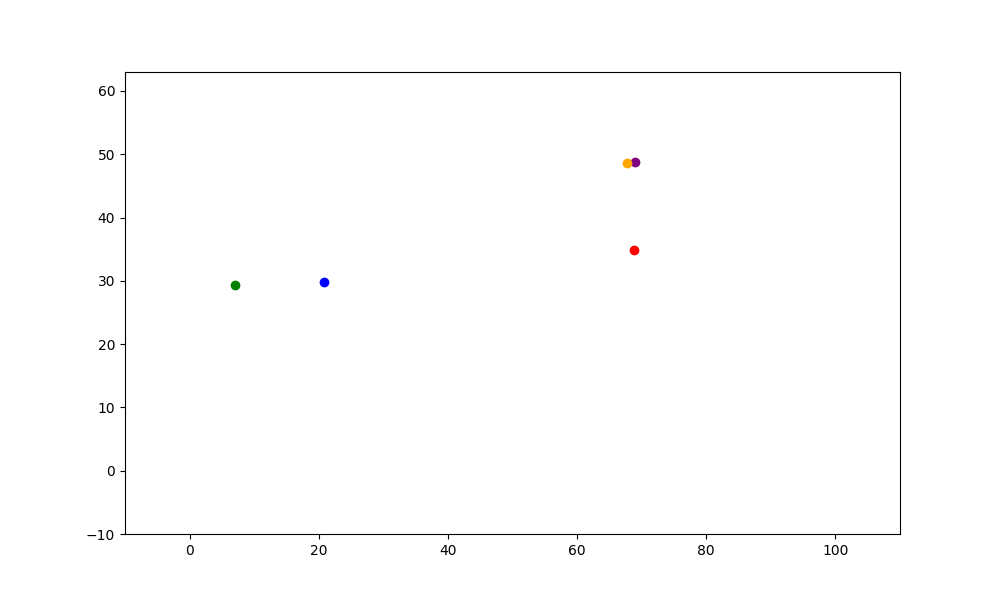

In [54]:
row = 1
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
c = 'blue'
football_x = model_data_df.iloc[row]['x_x'][0]
football_y = model_data_df.iloc[row]['y_x'][0]
ax.scatter(x=football_x, y=football_y, c=c)
c = 'green'
punter_x = model_data_df.iloc[row]['x_x'][1]
punter_y = model_data_df.iloc[row]['y_x'][1]
ax.scatter(x=punter_x, y=punter_y, c=c)
c = 'red'
returner_x = model_data_df.iloc[row]['x_x'][2]
returner_y = model_data_df.iloc[row]['y_x'][2]
ax.scatter(x=returner_x, y=returner_y, c=c)
c = 'purple'
actual_x = model_data_df.iloc[row]['x_y']
actual_y = model_data_df.iloc[row]['y_y']
ax.scatter(x=actual_x, y=actual_y, c=c)
c = 'orange'
predict_x = model_data_df.iloc[row]['nn_prediction'][0]
predict_y = model_data_df.iloc[row]['nn_prediction'][1]
ax.scatter(x=predict_x, y=predict_y, c=c)
plt.show()

In [55]:
model_data_df['linearRegressionAbsoluteError'] = (
    (model_data_df['x_y'] - model_data_df['prediction'].str[0]) ** 2 +
    (model_data_df['y_y'] - model_data_df['prediction'].str[1]) ** 2
) ** 0.5
model_data_df['neuralNetworkAbsoluteError'] = (
    (model_data_df['x_y'] - model_data_df['nn_prediction'].str[0]) ** 2 +
    (model_data_df['y_y'] - model_data_df['nn_prediction'].str[1]) ** 2
) ** 0.5

In [56]:
model_data_df['linearRegressionAbsoluteError'].mean()

11.073877284187004

In [57]:
model_data_df['neuralNetworkAbsoluteError'].mean()

9.41317906061383